In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from collections import Counter
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
import nltk
import os
import json
from time import sleep

In [2]:
#########################################
#### Preparing Dataset for the Model ####
#########################################

In [3]:
nlp = spacy.load("en")

In [4]:
# Calculate attributes

def token_word_count(text):
    # Return token count, individual word count, list of words
    token_list = []
    for token in text:
        if len(token)>0:
            if token.is_punct == False:
                token_list.append(token)
    return len(token_list), token_list

def remove_stop_words(token_list):
    filtered_token_list = [token for token in token_list if not token.text.lower() in STOP_WORDS and not token.is_punct]
    return len(filtered_token_list),filtered_token_list

def unique_words(token_list):
    word_list = []
    for token in token_list:
        word_list.append(token.text.lower())
    word_freq = Counter(word_list)
    unique_words = [word for (word, freq) in word_freq.items() if freq==1]
    return len(unique_words), unique_words

def rate_of_words(text):
    #Find rate of words in content
    token_count, token_list = token_word_count(text)
    if token_count != 0:
    
        non_stop_words_len, non_stop_words_tokens = remove_stop_words(token_list)

        # Rate of unique words in content
        unique_tokens, unique_token_list = unique_words(token_list)
        rate_of_unique_words = unique_tokens/token_count

        # Rate of non stop words
        rate_of_non_stop_words = (non_stop_words_len)/token_count

        # Rate of unique non stop words
        unique_non_stop_words, unique_non_stop_words_list = unique_words(non_stop_words_tokens)
        rate_of_unique_non_stop_words = (unique_non_stop_words)/unique_tokens 
        
        return rate_of_unique_words,rate_of_non_stop_words,rate_of_unique_non_stop_words
    else:
        return 'NaN','NaN','NaN'

# Input normal text
def text_sentiment(text):
    sent = TextBlob(text, analyzer = NaiveBayesAnalyzer())
    positive = sent.sentiment.p_pos
    negative = sent.sentiment.p_neg
    return positive, negative
    
def polarity_subjectivity(text): 
    return TextBlob(text).sentiment.polarity, TextBlob(text).sentiment.subjectivity

In [8]:
# Get list of data files
os.chdir(os.getcwd()+'/Data')
os.chdir(os.getcwd()+'/1')
data_items1 = os.listdir()
data_items1.sort()

In [7]:
# Checking attributes available
os.getcwd()
with open("news_0000028.json","r") as read_file:
    data = json.load(read_file)
    spam_score = data['thread']['spam_score']
    performance_score = data['thread']['performance_score']
    domain_rank = data['thread']['domain_rank']
    category = data['thread']['section_title']
    title = data['title']
    site_type = data['thread']['site_type']
#print(spam_score,performance_score,domain_rank,category)
print(json.dumps(data,sort_keys=True, indent=4))

{
    "author": "Shilpi Sampad&nbsp;",
    "crawled": "2017-02-02T06:57:30.498+02:00",
    "entities": {
        "locations": [
            {
                "name": "mumbai",
                "sentiment": "none"
            }
        ],
        "organizations": [],
        "persons": [
            {
                "name": "shekhar suman",
                "sentiment": "negative"
            },
            {
                "name": "sanjay dutt",
                "sentiment": "negative"
            },
            {
                "name": "kishore kumar",
                "sentiment": "none"
            },
            {
                "name": "aditi rao hydari",
                "sentiment": "none"
            },
            {
                "name": "shekhar",
                "sentiment": "none"
            },
            {
                "name": "adhyayan",
                "sentiment": "none"
            },
            {
                "name": "bhoomi",
                "sentiment": "n

In [8]:
# Making Dataset

def create_data(file):
        with open(file,"r") as read_file:
            data = json.load(read_file)
            # Content Attributes
            rate_of_unique_words_content,rate_of_non_stop_words_content,rate_of_unique_non_stop_words_content = rate_of_words(nlp(data['text']))
            positive_content, negative_content = text_sentiment(data['text'])
            polarity_content, subjectivity_content = polarity_subjectivity(data['text'])
            # Title Attributes
            rate_of_unique_words_title,rate_of_non_stop_words_title,rate_of_unique_non_stop_words_title = rate_of_words(nlp(data['title']))
            positive_title, negative_title = text_sentiment(data['title'])
            polarity_title, subjectivity_title = polarity_subjectivity(data['title'])
            # Other Attributes
            site_type = data['thread']['site_type']
            shares = data['thread']['social']['facebook']['shares']
            likes = data['thread']['social']['facebook']['likes']
            return ({'rate_of_unique_words_content': rate_of_unique_words_content,
                              'rate_of_non_stop_words_content': rate_of_non_stop_words_content,
                              'rate_of_unique_non_stop_words_content': rate_of_unique_non_stop_words_content,
                              'positive_content': positive_content,
                              'negative_content': negative_content,
                              'polarity_content': polarity_content,
                              'subjectivity_content': subjectivity_content,
                              'rate_of_unique_words_title': rate_of_unique_words_title,
                              'rate_of_non_stop_words_title': rate_of_non_stop_words_title,
                              'rate_of_unique_non_stop_words_title': rate_of_unique_non_stop_words_title,
                              'positive_title': positive_title,
                              'negative_title': negative_title,
                              'polarity_title': polarity_title,
                              'subjectivity_title': subjectivity_title,
                              'site_type':site_type,
                    'shares':shares,
                    'likes':likes})

In [ ]:
# Using parallel processing to complete the dataset

import math
import multiprocessing
from joblib import Parallel, delayed
import progressbar
from tqdm import tqdm


# set up parameters required by the task
data_items1 = os.listdir()
data_items1.sort()
inputs = tqdm(data_items1)
    
num_cores = multiprocessing.cpu_count()
if __name__ == "__main__":
    data_frame = Parallel(n_jobs=num_cores)(delayed(create_data)(data_items1[i]) for i in range(10000))

In [ ]:
data_frame

In [ ]:
# Write created dataset to csv file
df = pd.DataFrame(data_frame)
df.to_csv(r'Data.csv',index = False, header = True)

In [6]:
#########################################
### Preprocessing Data for the Model ###
#########################################

In [12]:
df = pd.read_csv('Data_Final.csv')
df = df.dropna(axis=0)

In [13]:
# Drop NaN values and convert to float
df1 = df[df.rate_of_unique_words_content != 'NaN']
df1 = df1[df1.rate_of_non_stop_words_content != 'NaN']
df1 = df1[df1.rate_of_unique_non_stop_words_content != 'NaN']
df1.rate_of_unique_words_content = df1.rate_of_unique_words_content.apply(float)
df1.rate_of_non_stop_words_content = df1.rate_of_non_stop_words_content.apply(float)
df1.rate_of_unique_non_stop_words_content = df1.rate_of_unique_non_stop_words_content.apply(float)

/Users/ram/opt/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [14]:
df1 = df
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9975 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   rate_of_unique_words_content           9975 non-null   float64
 1   rate_of_non_stop_words_content         9975 non-null   float64
 2   rate_of_unique_non_stop_words_content  9975 non-null   float64
 3   positive_content                       9975 non-null   float64
 4   negative_content                       9975 non-null   float64
 5   polarity_content                       9975 non-null   float64
 6   subjectivity_content                   9975 non-null   float64
 7   rate_of_unique_words_title             9975 non-null   float64
 8   rate_of_non_stop_words_title           9975 non-null   float64
 9   rate_of_unique_non_stop_words_title    9975 non-null   float64
 10  positive_title                         9975 non-null   float64
 11  nega

In [15]:
df1.describe()

,rate_of_unique_words_content,rate_of_non_stop_words_content,rate_of_unique_non_stop_words_content,positive_content,negative_content,polarity_content,subjectivity_content,rate_of_unique_words_title,rate_of_non_stop_words_title,rate_of_unique_non_stop_words_title,positive_title,negative_title,polarity_title,subjectivity_title,shares,likes
count,9975.000000,9975.000000,9975.000000,9975.000000,9.975000e+03,9975.000000,9975.000000,9975.000000,9975.000000,9975.000000,9975.000000,9975.000000,9975.000000,9975.000000,9975.000000,9975.000000
mean,0.392684,0.583388,0.800068,0.950438,4.956233e-02,0.091155,0.415520,0.966843,0.754845,0.761666,0.639674,0.360326,0.039651,0.236356,347.248622,351.285614
std,0.151921,0.086918,0.072936,0.176662,1.766624e-01,0.117596,0.122831,0.077288,0.136818,0.135229,0.268347,0.268347,0.240058,0.308526,233.528405,443.320420
min,0.003300,0.304348,0.200000,0.000030,5.961033e-256,-1.000000,0.000000,0.166667,0.111111,0.111111,0.003238,0.000210,-1.000000,0.000000,0.000000,101.000000
25%,0.303680,0.532384,0.757962,0.999772,3.726485e-16,0.028792,0.358414,1.000000,0.666667,0.666667,0.453832,0.121345,0.000000,0.000000,157.000000,157.000000
50%,0.363148,0.571545,0.806897,1.000000,3.657715e-09,0.091342,0.423413,1.000000,0.764706,0.769231,0.677647,0.322353,0.000000,0.000000,266.000000,266.000000
75%,0.442015,0.613204,0.848028,1.000000,2.277043e-04,0.151254,0.483098,1.000000,0.857143,0.857143,0.878655,0.546168,0.068182,0.454545,481.000000,481.000000
max,1.000000,1.000000,1.000000,1.000000,9.999700e-01,0.900000,1.000000,1.000000,1.000000,1.000000,0.999790,0.996762,1.000000,1.000000,999.000000,37973.000000


/Users/ram/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


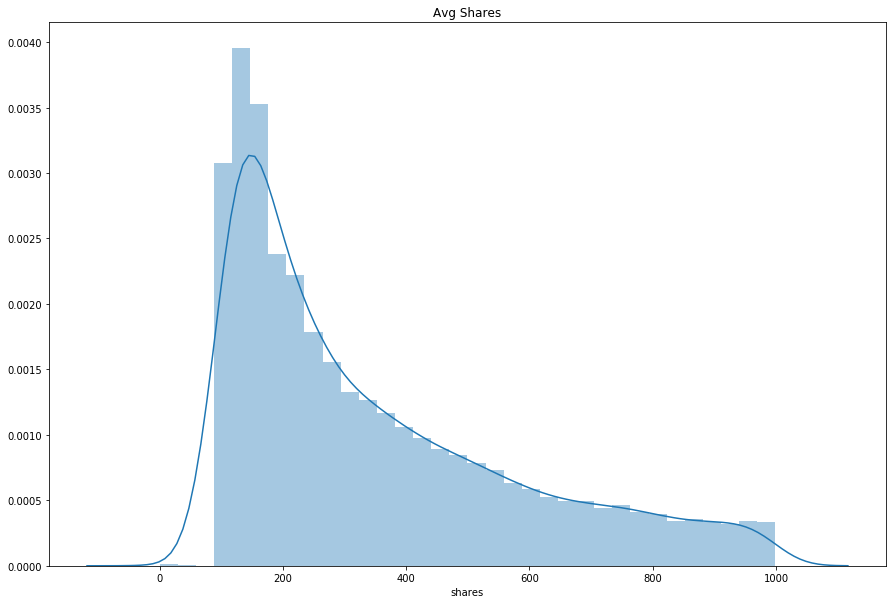

In [16]:
plt.figure(figsize=(15,10))
plt.tight_layout()
plt.title('Avg Shares')
sns.distplot(df1['shares'])

In [31]:
# Getting dependent and Independent data from the data
X = df1.iloc[:,[0,1,2,3,4,5,6,7,8,9,10,11,12,13]].values
y = df1.iloc[:,15].values
# Consider taking it as viral is shares are more than 350
y_final = (y / 1000)

In [32]:
#########################################
########## Preparing the Model ##########
#########################################

In [33]:
from sklearn.model_selection import train_test_split
# Split into training and test datasets
X_train, X_test, y_train, y_test = train_test_split(X,y_final,test_size=0.3, random_state=42)

In [34]:
y_test.reshape(-1, 1)

array([[0.922],
       [0.237],
       [0.325],
       ...,
       [0.314],
       [0.978],
       [0.151]])

In [35]:
X_train[1]

array([3.66771160e-01, 5.26645768e-01, 7.52136752e-01, 1.00000000e+00,
       1.17516047e-13, 1.65438596e-01, 5.51228070e-01, 1.00000000e+00,
       8.00000000e-01, 8.00000000e-01, 9.94642111e-01, 5.35788925e-03,
       1.60000000e-01, 5.40000000e-01])

In [36]:
def accuracy_score(true,pred):
    return len(np.arange(len(true))[true==pred])/len(true)

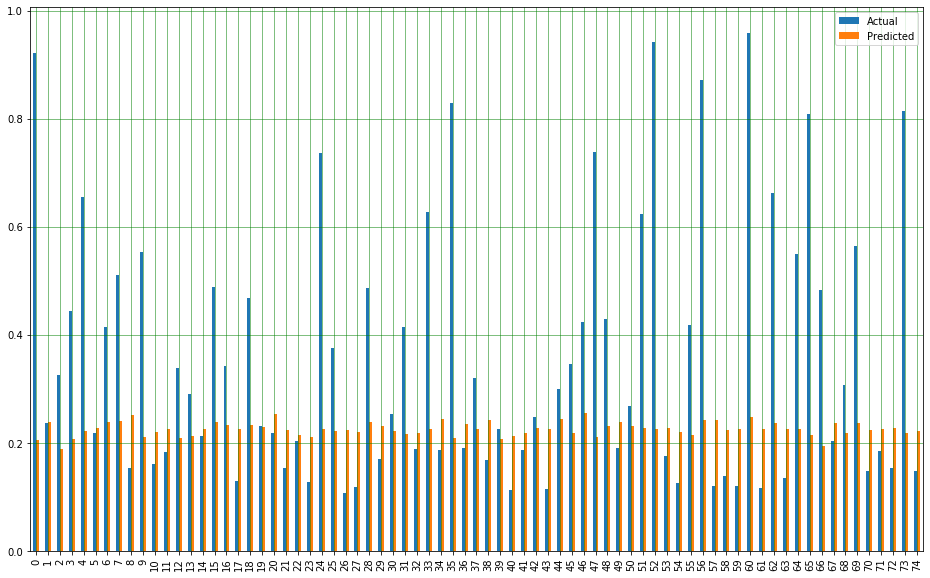

Accuracy Score:  0.7557634480454394


In [37]:
# Create models
from sklearn.linear_model import LinearRegression
from sklearn import metrics
# Linear Regression
linear_regressor_model =  LinearRegression()
linear_regressor_model.fit(X_train,y_train.round())
y_pred_linear = linear_regressor_model.predict(X_test)
# Bar Graph
linear_regression_predicted = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_linear})
linear_regression_predicted.head(75).plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()
print('Accuracy Score: ',accuracy_score(y_test.round(),y_pred_linear.round()))

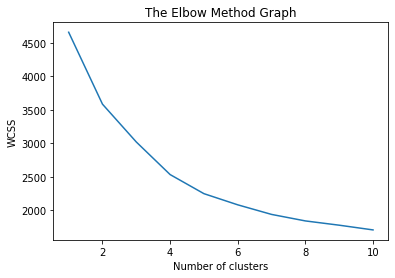

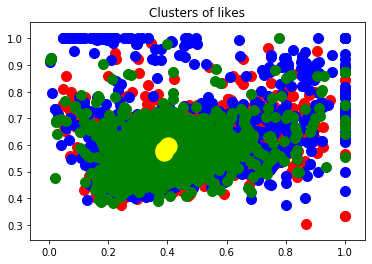

Cluster Centers:  [[ 0.38725798  0.58019572  0.80142155  0.98096822  0.01903178  0.08370637
   0.39924488  0.96733761  0.76632238  0.77368064  0.82263305  0.17736695
  -0.01079149  0.06513518]
 [ 0.40346117  0.59547157  0.80058943  0.89696001  0.10303999  0.0794496
   0.40397823  0.9681332   0.7545029   0.76062883  0.33122792  0.66877208
  -0.00978706  0.15938015]
 [ 0.38789863  0.57265786  0.79683972  0.96748451  0.03251549  0.12110923
   0.46162819  0.96414765  0.73401802  0.74079835  0.72525533  0.27474467
   0.20139252  0.66017476]]
Accuracy Score:  0.41092731829573936


In [38]:
# K-Means
from sklearn.cluster import KMeans
wcss=[]
for i in range(1,11): 
    kmeans = KMeans(n_clusters=i, init ='k-means++', max_iter=300,  n_init=10,random_state=0 )
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
# Elbow graph
plt.plot(range(1,11),wcss)
plt.title('The Elbow Method Graph')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()
# Clusters based on graph
kmeans = KMeans(n_clusters=3, init ='k-means++', max_iter=300, n_init=10,random_state=0 )
y_kmeans = kmeans.fit_predict(X)
plt.scatter(X[y_kmeans==0, 0], X[y_kmeans==0, 1], s=100, c='red', label ='Cluster 1')
plt.scatter(X[y_kmeans==1, 0], X[y_kmeans==1, 1], s=100, c='blue', label ='Cluster 2')
plt.scatter(X[y_kmeans==2, 0], X[y_kmeans==2, 1], s=100, c='green', label ='Cluster 3')
#Plot the centroid, we're going to use the cluster centres  attribute that returns here the coordinates of the centroid.
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='yellow', label = 'Centroids')
plt.title('Clusters of likes')
plt.show()
print('Cluster Centers: ', kmeans.cluster_centers_)
print('Accuracy Score: ',accuracy_score(y_final.round(),y_kmeans.round()))

In [39]:
# XGBoost 
from xgboost import XGBClassifier
xgb_classifier = XGBClassifier()
xgb_classifier.fit(X_train, y_train.round())

# Predicting the Test set results
y_xgb_pred = xgb_classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test.round(), y_xgb_pred)

# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = xgb_classifier, X = X_train, y = y_train.round(), cv = 10)
accuracies.mean()
accuracies.std()

0.011975227280598306

In [41]:
# Saving the best performing model which is Linear Regression
import pickle
filename = 'final_model.sav'
pickle.dump(linear_regressor_model, open(filename, 'wb'))